#### AnDA with IBTrACS as catalog (M) and SCT/RAD as observations (Y)

Uses CSV files of 00_create_csv_AnDA_v02.ipynb.



In [1]:
### IMPORT LIBRARIES

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize']=(20,20) # graph size

import os

# pandas and statsmodels
import pandas
from statsmodels.stats.weightstats import DescrStatsW

# analog data assimilation
from AnDA_codes.AnDA_generate_data import AnDA_generate_data
from AnDA_codes.AnDA_analog_forecasting import AnDA_analog_forecasting
from AnDA_codes.AnDA_model_forecasting import AnDA_model_forecasting
from AnDA_codes.AnDA_data_assimilation import AnDA_data_assimilation
from AnDA_codes.AnDA_stat_functions import AnDA_RMSE

# Matplotlib
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# TC name
TC_name = 'wp132015_SOUDELOR'  # SAR ==> Rmax stays around 15km during whole intensification (from 26m/s to 80m/s). GREAT EXAMPLE
# TC_name = 'al182021_SAM'
# TC_name = 'al052019_DORIAN'

PATHS = {
    'data_dir': '/home/arthur/scripts/TCsLifeMonitFromObs/AnDA/AnDA_data/IBTrACS_V9/',
    'results':  '/home/arthur/results/TCsLifeMonitFromObs/AnDA/03_AnDA_M_IBTrACS_Y_SCT_RAD_intv01/',
}

PARAMS = {
    'nb_analogs': 100, # nb of analogs
    'sigma2_obs': 0.05, # variance of the observations
    'save_fig':   False, 
}

In [3]:
### GENERATE THE CATALOG, THE TRUE STATE, AND THE OBSERVATIONS
files = os.listdir(PATHS['data_dir'])
print('Total nb of files: {}'.format(len(files)))

# Create the catalog: put all files except the current one
# Initialization
class catalog:
    IBTrACS_tmp = array(pandas.read_csv(PATHS['data_dir'] + files[0], usecols = ['Vmax', 'Rmax', 'R34', 'fcor']))
    analogs     = IBTrACS_tmp[0:-1,:]
    successors  = IBTrACS_tmp[1:,:]
# Loop over all files (except current one)
for i in arange(1, len(files)):
    if files[i] != TC_name:
        IBTrACS_tmp        = array(pandas.read_csv(PATHS['data_dir'] + files[i], usecols = ['Vmax', 'Rmax', 'R34', 'fcor']))
        catalog.analogs    = concatenate([catalog.analogs, IBTrACS_tmp[0:-1,:]])
        catalog.successors = concatenate([catalog.successors, IBTrACS_tmp[1:,:]])
    else:
        class xt: # Reference
            time   = []
            values = []
        IBTrACS_tmp = array(pandas.read_csv(PATHS['data_dir'] + files[i], usecols = ['Vmax', 'Rmax', 'R34', 'fcor']))
        xt.time     = range(shape(IBTrACS_tmp)[0])                        # Timestep: 0, 1, ...., 30, 31, ...
        xt.datetime = array(pandas.read_csv(PATHS['data_dir'] + files[i])['Time']) # Date_time: np.datetime64(2015, 08, 07, 00), np.datetime64(2015, 08, 07, 03), ...
        xt.sar_obs  = array(pandas.read_csv(PATHS['data_dir'] + files[i], usecols = ['vmx_sar', 'rmx_sar', 'r34_sar']))
        xt.values   = IBTrACS_tmp
        class yo: # Observations
            time   = []
            values = []
        IBTrACS_tmp = array(pandas.read_csv(PATHS['data_dir'] + files[i], usecols = ['Vmax', 'Rmax', 'R34', 'fcor']))
        yo.time     = range(shape(IBTrACS_tmp)[0])
        yo.values   = IBTrACS_tmp
        yo.values[:, 0] = pandas.read_csv(PATHS['data_dir'] + files[i])['vmx_obs']
        yo.values[:, 1] = pandas.read_csv(PATHS['data_dir'] + files[i])['rmx_obs']
        yo.values[:, 2] = pandas.read_csv(PATHS['data_dir'] + files[i])['r34_obs']
        
        # yo.values[:, 1] = NaN # remove observations of Rmax

# center and reduce the 6 columns
mean_IBTrACS = mean(catalog.analogs, axis=0)
std_IBTrACS  = std(catalog.analogs, axis=0)
for j in range(shape(catalog.analogs)[1]):
    catalog.analogs[:,j]    = (catalog.analogs[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    catalog.successors[:,j] = (catalog.successors[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    xt.values[:,j] = (xt.values[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    yo.values[:,j] = (yo.values[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]

Total nb of files: 285


In [4]:
### ANALOG DATA ASSIMILATION (dynamical model given by the catalog)
n = shape(catalog.analogs)[1] # Nb. of parameters in the reconstructed state

# parameters of the analog forecasting method
class AF:
    k            = PARAMS['nb_analogs'] # number of analogs
    neighborhood = np.ones(n)           # global analogs
    catalog      = catalog              # catalog with analogs and successors
    regression   = 'local_linear'       # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling     = 'gaussian'           # chosen sampler ('gaussian', 'multinomial')

# parameters of the filtering method
class DA:
    method = 'AnEnKS' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N      = 1000     # number of members (AnEnKF/AnEnKS) or parti8-10-cles (AnPF)
    xb     = xt.values[0,:]; B = np.eye(n)
    H      = np.eye(n)
    R      = PARAMS['sigma2_obs'] * np.eye(n)
    @staticmethod
    def m(x):
        return AnDA_analog_forecasting(x, AF)
    
# run the analog data assimilation
x_hat_analog = AnDA_data_assimilation(yo, DA)

100%|██████████████████████████████████████████| 31/31 [00:00<00:00, 221.53it/s]


In [5]:
# compute weighted quantiles
x_hat_analog_quantiles = zeros([shape(x_hat_analog.part)[0], 7, n])
for t in range(shape(x_hat_analog.part)[0]):
    for j in range(n):
        wq = DescrStatsW(data=x_hat_analog.part[t,:,j], weights=x_hat_analog.weights[t,:])
        x_hat_analog_quantiles[t,:,j] = wq.quantile(probs=np.array([0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]), return_pandas=False)

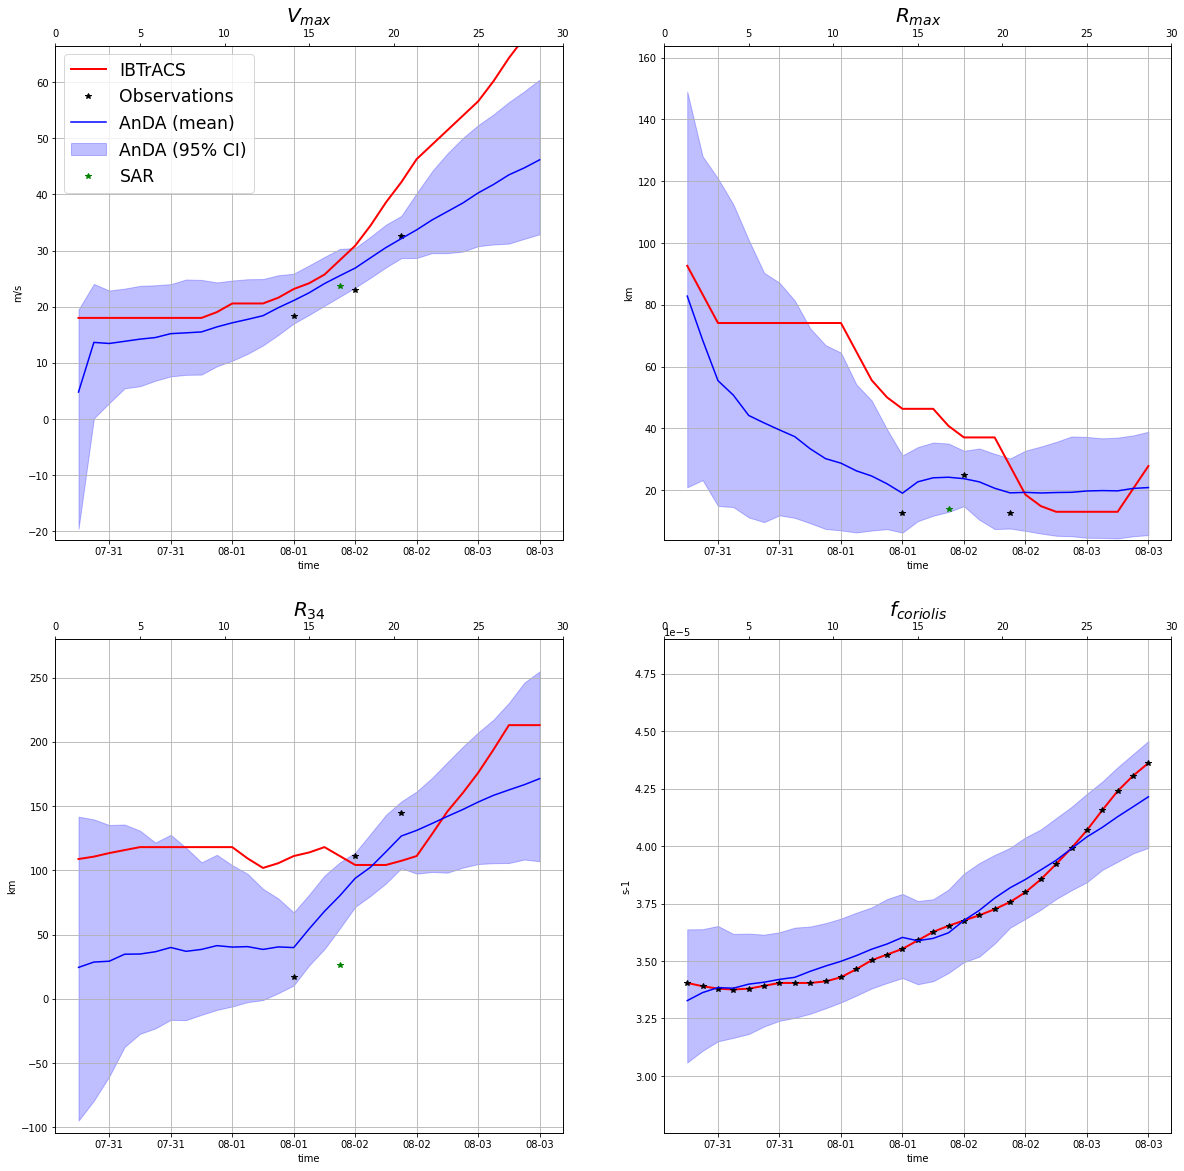

In [6]:
### Plot Vmax, Rmax, R34, f, U, V
tab_title = ['$V_{max}$', '$R_{max}$', '$R_{34}$', '$f_{coriolis}$']
plt_legds = [['time', 'm/s'], ['time', 'km'], ['time', 'km'], ['time', 's-1']]

# Define plot limits
q025_lims = [[min(x_hat_analog_quantiles[:, 0, j] * std_IBTrACS[j] + mean_IBTrACS[j]), max(x_hat_analog_quantiles[:, 0, j] * std_IBTrACS[j] + mean_IBTrACS[j])] for j in range(xt.values.shape[1])]
q975_lims = [[min(x_hat_analog_quantiles[:, 6, j] * std_IBTrACS[j] + mean_IBTrACS[j]), max(x_hat_analog_quantiles[:, 6, j] * std_IBTrACS[j] + mean_IBTrACS[j])] for j in range(yo.values.shape[1])]
y_lims    = [[np.nanmin((q025_lim[0], q975_lim[0])), np.nanmax((q025_lim[1], q975_lim[1]))] for q025_lim, q975_lim in zip(q025_lims, q975_lims)]
for idx, (left, right) in enumerate(y_lims):
    if left > 0:
        y_lims[idx][0] *= 0.9
    else:
        y_lims[idx][0] *= 1.1
    if right > 0:
        y_lims[idx][1] *= 1.1
    else:
        y_lims[idx][1] *= 0.9

# Plot
fig, axs = plt.subplots(nrows=2, ncols=2)
for j, ax in enumerate(fig.axes):
    ax.plot(xt.datetime.astype(datetime64), xt.values[:, j] * std_IBTrACS[j] + mean_IBTrACS[j], '-r', linewidth=2)
    ax.plot(xt.datetime.astype(datetime64), yo.values[:, j] * std_IBTrACS[j] + mean_IBTrACS[j], '*k')
    ax.plot(xt.datetime.astype(datetime64), x_hat_analog_quantiles[:, 3, j] * std_IBTrACS[j] + mean_IBTrACS[j], '-b')
    ax.grid()
    ax.set_xlabel(plt_legds[j][0]);ax.set_ylabel(plt_legds[j][1])
    ax.fill_between(xt.datetime.astype(datetime64), x_hat_analog_quantiles[:, 0, j] * std_IBTrACS[j] + mean_IBTrACS[j], x_hat_analog_quantiles[:, 6, j] * std_IBTrACS[j] + mean_IBTrACS[j], alpha=0.25, color='b')
    ax.set_ylim(y_lims[j])
    ax.set_title(tab_title[j], size=20)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%m-%d"))
    ax1 = ax.twiny()
    ax1.set_xticks(xt.time[::5])
    ax1.set_xticklabels(xt.time[::5])
    # SAR observations
    if j < 3:
        ax.plot(xt.datetime.astype(datetime64), xt.sar_obs[:, j], '*g')
    if j==0:
        ax.legend(['IBTrACS', 'Observations', 'AnDA (mean)', 'AnDA (95% CI)', 'SAR'], loc=0, fontsize='xx-large')
        
    if PARAMS['save_fig']:
        plt.savefig(PATHS['results'] + TC_name + '_{}anlgs'.format(PARAMS['nb_analogs']), bbox_inches = 'tight')